In [1]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import dill

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes)
from cities.utils.cleaning_utils import check_if_tensed, find_repo_root
from cities.modeling.model_interactions import model_cities_interaction
from cities.modeling.model_interactions import InteractionsModel
from cities.modeling.modeling_utils import (prep_wide_data_for_inference, train_interactions_model)
from cities.utils.cleaning_utils import find_repo_root


In [2]:
list_interventions = list_interventions()
print(list_interventions)

['spending_HHS', 'spending_commerce', 'spending_transportation']


[iteration 0001] loss: 143574.8868


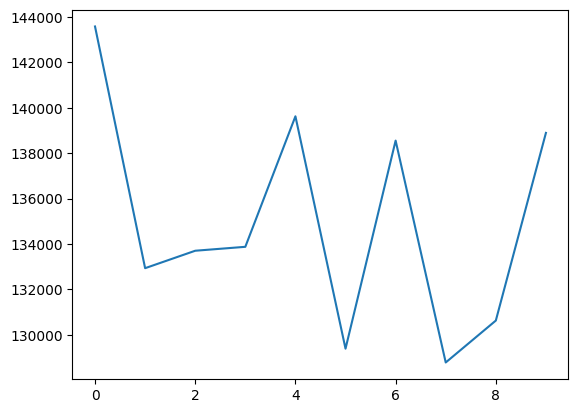

In [4]:
transportation_warehousing_model = InteractionsModel(
    outcome_dataset= 'industry_transportation_warehousing_total',
intervention_dataset='spending_transportation',
forward_shift = 3,
num_iterations= 10,
num_samples= 10,
plot_loss= True
)

transportation_warehousing_model.train_interactions_model()

transportation_warehousing_model.sample_from_guide()

transportation_warehousing_model.save_guide()

In [3]:
outcome_dataset= 'industry_transportation_warehousing_total'
intervention_dataset='spending_transportation'
forward_shift = 3


In [4]:
data = prep_wide_data_for_inference(
    outcome_dataset= outcome_dataset,
    intervention_dataset=intervention_dataset,
    forward_shift = forward_shift
)

model_args = data['model_args']

In [6]:
model_cities_interaction_conditioned =  pyro.condition(
            model_cities_interaction,
            data={"T": data['t'], "Y": data['y'], 
                  "X": data['x']},
        )

[iteration 0001] loss: 139298.2257
[iteration 0101] loss: -2947.8007
[iteration 0201] loss: -95050.0423
[iteration 0301] loss: -122181.3327
[iteration 0401] loss: -132098.3548
[iteration 0501] loss: -133689.2840
[iteration 0601] loss: -134546.1894
[iteration 0701] loss: -135372.8518
[iteration 0801] loss: -134853.6297
[iteration 0901] loss: -133400.0718


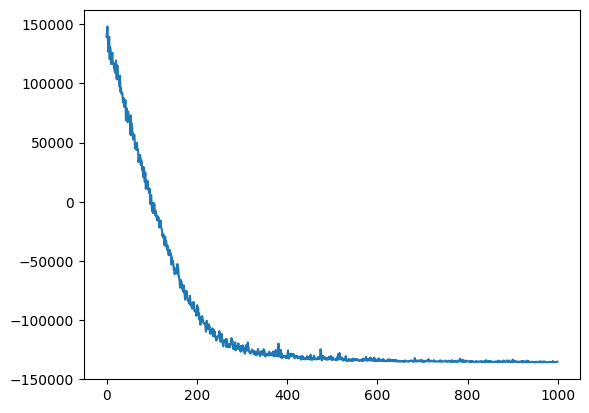

In [7]:
guide, plot = train_interactions_model(model_cities_interaction_conditioned, model_args,
                            num_iterations = 1000,
                            plot_loss = True,
                            print_interval = 100,
                            lr = 0.01)

In [8]:
predictive = Predictive(model=model_cities_interaction, guide=guide, num_samples=1000, parallel=False)
samples = predictive(*model_args)


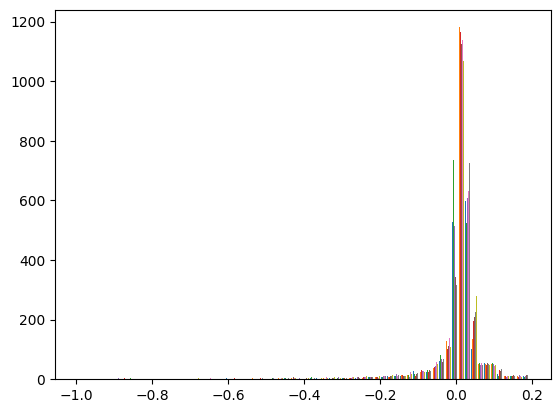

In [9]:
# plot residuals
predictions = samples['Y'].squeeze()
average_predictions = torch.mean(predictions, dim=0)
plt.hist(average_predictions -data['y'].squeeze(), bins=70)
plt.show()


tensor(-0.0045)
tss tensor(281.9242)
torch.Size([27666])
rss tensor(243.3187)
r_squared tensor(0.1369)


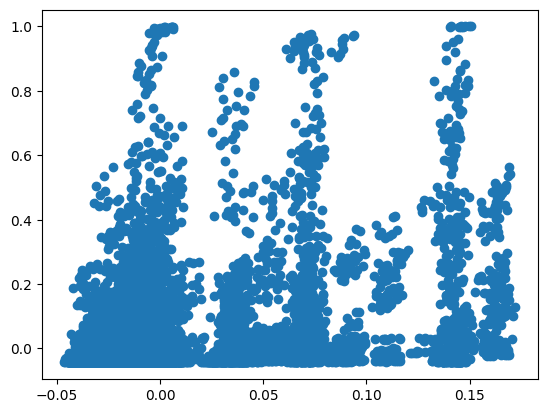

In [10]:
y_flat = data['y'].view(-1)

observed_mean = torch.mean(y_flat)
print(observed_mean)

tss = torch.sum((y_flat- observed_mean) ** 2)
print("tss", tss)

average_predictions_flat = average_predictions.view(-1)
print(average_predictions_flat.shape)

plt.scatter(average_predictions_flat, y_flat)

rss = torch.sum((y_flat- average_predictions_flat) ** 2)
print("rss", rss)
r_squared = 1 - (rss / tss)
print("r_squared", r_squared)

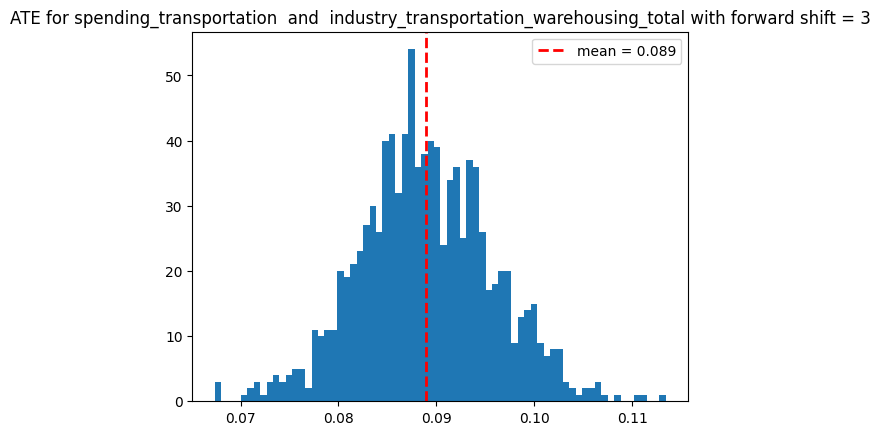

In [11]:
tau_samples = samples['weight_TY'].squeeze().detach().numpy()

plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title(f"ATE for {intervention_dataset}  and  {outcome_dataset} with forward shift = {forward_shift}")
plt.legend()
plt.show()